In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
    
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm

import random, time

from torch.utils.tensorboard import SummaryWriter

from datasets import synthetic as load_datasets
from datasets import real as load_real_datasets
from datasets import real_only as load_only_real_datasets
from utils import plotter, visualizer

import metrics
from models import PVT, UNet, ResNet, ConvNext, ViT

import trainer as train_funct
from trainer import Trainer

/home/firp/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/firp/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
writer = SummaryWriter()

In [3]:
train_funct.set_seed(42)

## Dataset

In [4]:
train_datapath = "Datasets/Training_set"
val_datapath = "Datasets/Validation_set"
test_datapath = "Datasets/Test_set"

In [5]:
train_data = load_datasets.SonarDescriptorDatasetFull(train_datapath, None)
val_data = load_datasets.SonarDescriptorDatasetFull(val_datapath, train_data)
test_data = load_datasets.SonarDescriptorDatasetFull(test_datapath, train_data)

In [6]:
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Training: 31375
Validation: 4000
Test: 4000


In [7]:
real_data = load_real_datasets.SonarDescriptorRealDataset(None, None)

In [8]:
print("Real: " + str(len(real_data.imgs)))

Real: 2182


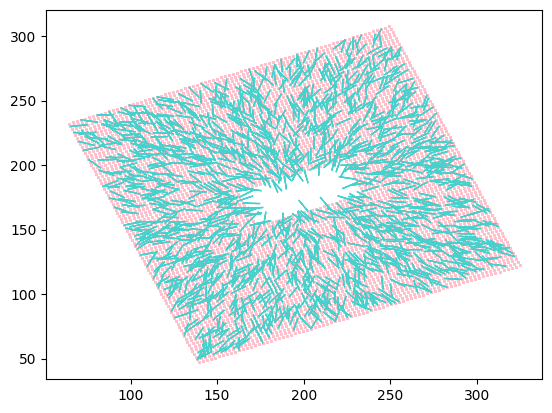

In [9]:
plotter.plot_train_data(train_data)

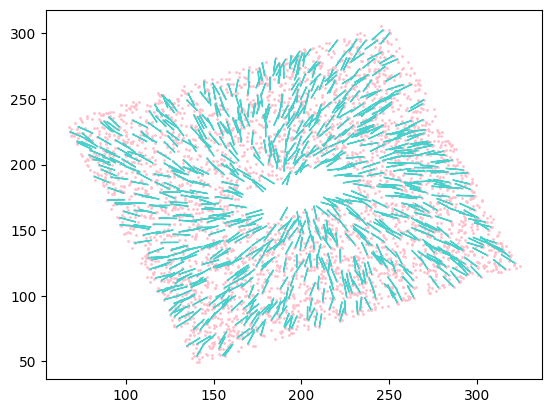

In [10]:
plotter.plot_data(val_data)

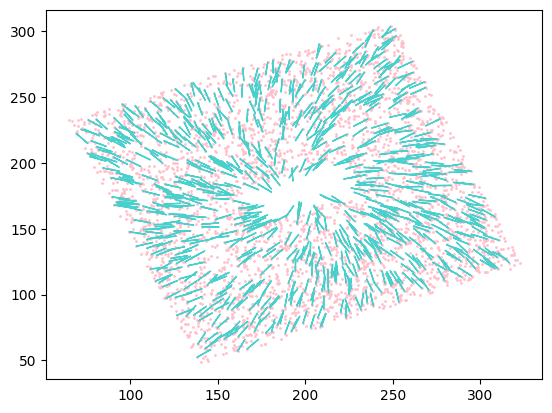

In [11]:
plotter.plot_data(test_data)

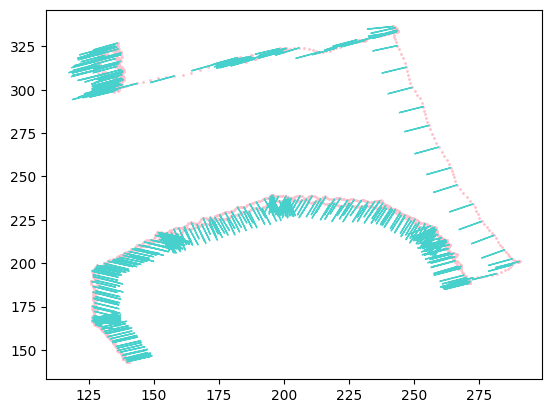

In [12]:
plotter.plot_data(real_data)

In [13]:
q_pose = real_data.poses[700]

q_x, q_y, q_Y_deg = q_pose
q_pose = np.array([q_x, q_y, (90+q_Y_deg)%360])

gt_pose_idx = train_data.gtquery(q_x, q_y, q_Y_deg)

Training before filtering: 31375


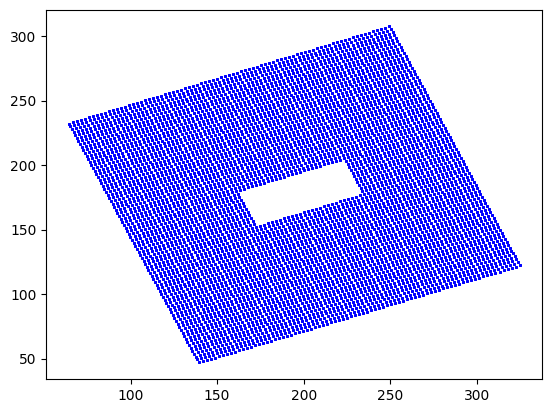

In [14]:
plotter.plot_synth_poses_train(train_data, "blue")
print("Training before filtering: " + str(len(train_data.imgs)))

Filtering poses: 100%|████████████████| 31375/31375 [00:00<00:00, 384559.58it/s]


Train after filtering: 26560


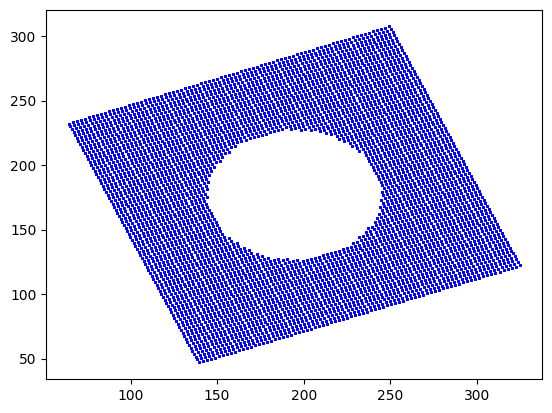

In [15]:
visualizer.filter_train_data(train_data)

plotter.plot_synth_poses_train(train_data, "blue")

print("Train after filtering: " + str(len(train_data.imgs)))

Validation before filtering: 4000


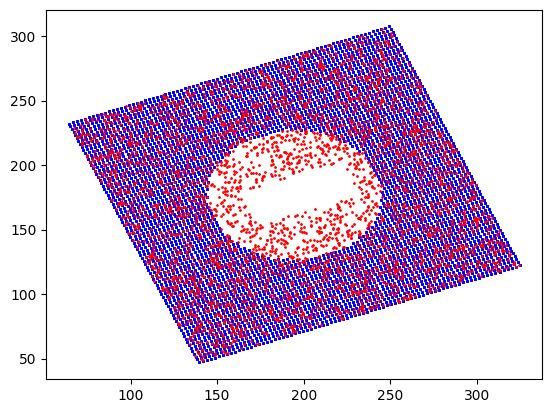

In [16]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation before filtering: " + str(len(val_data.imgs)))

Filtering poses: 100%|████████████████████| 4000/4000 [00:02<00:00, 1880.44it/s]


Validation after filtering: 3490


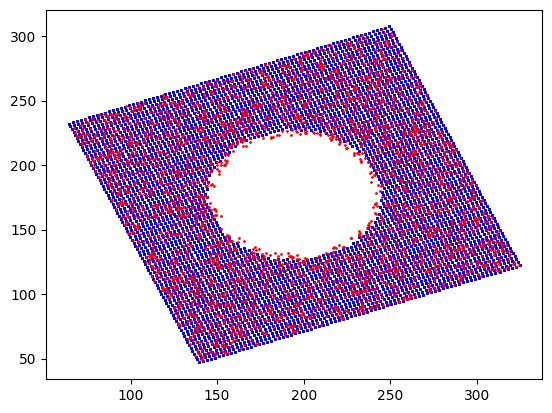

In [17]:
visualizer.filter_data(train_data, val_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation after filtering: " + str(len(val_data.imgs)))

Test before filtering: 4000


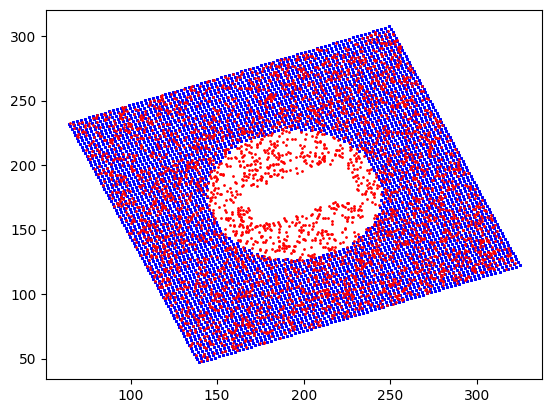

In [18]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test before filtering: " + str(len(test_data.imgs)))

Filtering poses: 100%|████████████████████| 4000/4000 [00:02<00:00, 1871.46it/s]


Test after filtering: 3502


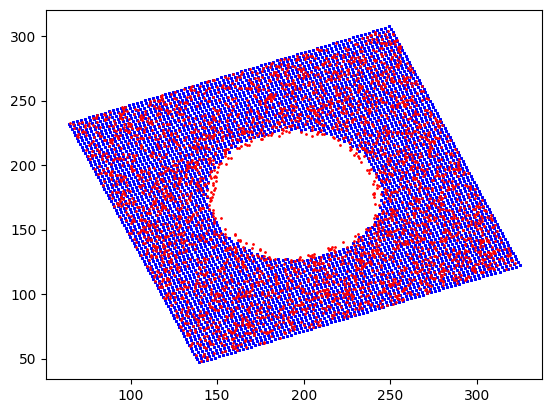

In [19]:
visualizer.filter_data(train_data, test_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test after filtering: " + str(len(test_data.imgs)))

iou: 0.9582056792165464
yaw difference tensor(4.9431) deg
localization error:  0.032426458 meters


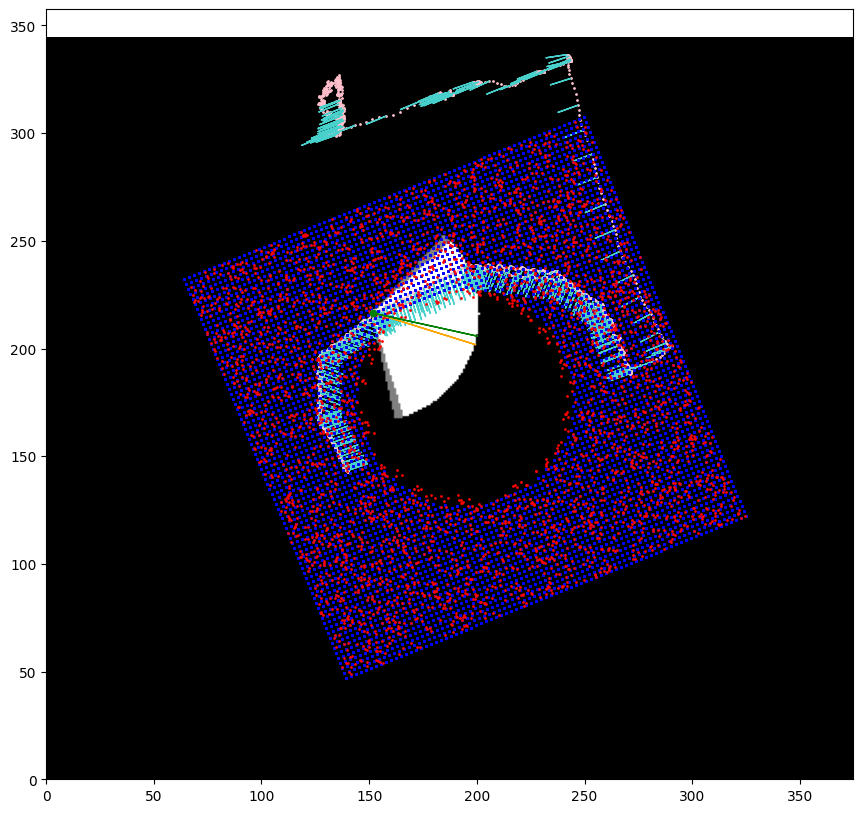

<Figure size 640x480 with 0 Axes>

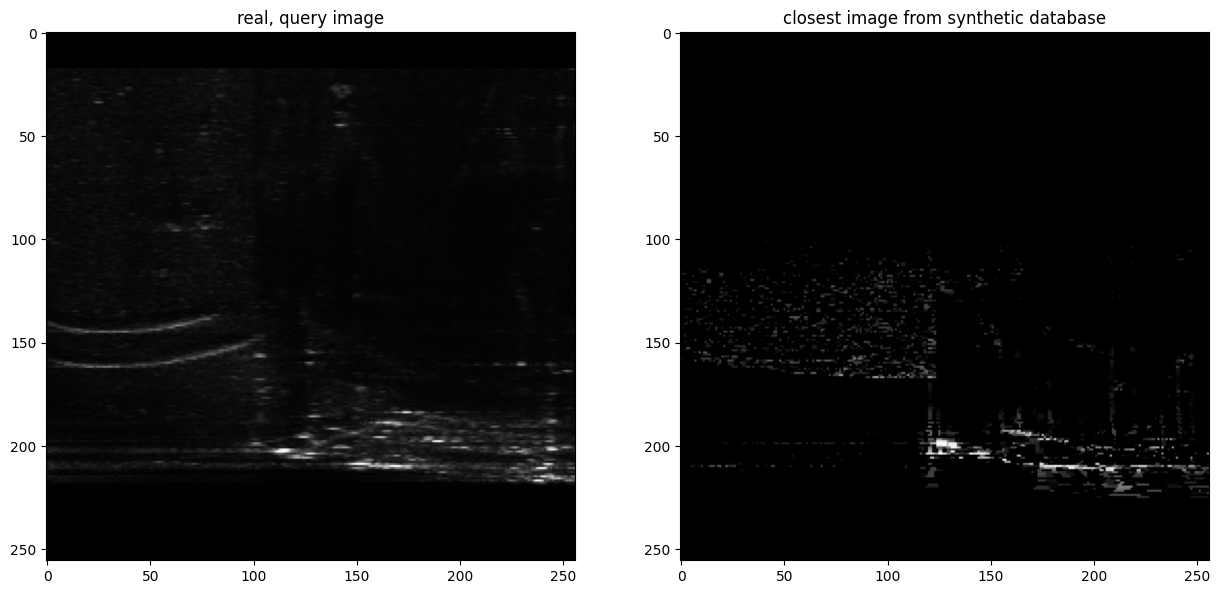

In [20]:
visualizer.localization(train_data, val_data, real_data)

In [21]:
print("Datasets before ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets before ground truth check
Training: 26560
Validation: 3490
Test: 3502


In [22]:
val_data = visualizer.check_gt(train_data, val_data)

In [23]:
test_data = visualizer.check_gt(train_data, test_data)

In [24]:
print("Datasets after ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets after ground truth check
Training: 26560
Validation: 3488
Test: 3496


In [25]:
model_name = "PVT_r"

In [26]:
batch = 16
train_dataloader = DataLoader(train_data, batch_size=batch, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch, shuffle=True)

## Model

### Model instantiation

In [27]:
net = PVT.Model().cuda()
net.train()

optimizer = torch.optim.AdamW(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.8)

drop = torch.nn.Dropout(0.3).cuda()

In [28]:
locacriterion = torch.nn.CrossEntropyLoss().cuda()
recocriterion = torch.nn.MSELoss().cuda()

In [29]:
total_params = metrics.count_parameters(net)
print("Total parameters: ", total_params)

Total parameters:  20571337


## Training Pipeline

### Train epochs

In [30]:
trainer = Trainer(writer, train_data, train_dataloader, val_data, val_dataloader, net, optimizer, scheduler, drop, recocriterion, locacriterion)
num_epochs = 12

start_train = time.time()
best_model_path, best_val_loca_error, best_val_orie_error = trainer.train(num_epochs)
end_train = time.time()

training_time = end_train - start_train
print("Training time: ", training_time, "seconds")

epoch: 1


100%|███████████████████████████████████████| 1660/1660 [27:32<00:00,  1.00it/s]


train loss mean: 0.10856570305347622
train loss reco: 0.013220080901750824
train loss loca: 0.009534561672915581


100%|█████████████████████████████████████████| 218/218 [02:03<00:00,  1.76it/s]


val loss mean: 0.01556139921666969
val loss reco: 0.002380201071842548
val loss loca: 0.0013181198080745313
computing dataset descriptors


100%|█████████████████████████████████████| 26560/26560 [04:54<00:00, 90.31it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3488/3488 [00:38<00:00, 90.14it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:58<00:00,  7.28it/s]


average localization error: 5.7563 meters
average orientation error : 49.7202 degrees
epoch: 2


100%|███████████████████████████████████████| 1660/1660 [26:58<00:00,  1.03it/s]


train loss mean: 79320.00204803461
train loss reco: 79319.98567880757
train loss loca: 0.0016373254009341693


100%|█████████████████████████████████████████| 218/218 [02:00<00:00,  1.81it/s]


val loss mean: 0.4755614830539861
val loss reco: 0.4754266786739367
val loss loca: 1.3480424029594277e-05
computing dataset descriptors


100%|█████████████████████████████████████| 26560/26560 [04:32<00:00, 97.37it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3488/3488 [00:35<00:00, 98.35it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:58<00:00,  7.29it/s]


average localization error: 11.4951 meters
average orientation error : 89.9771 degrees
epoch: 3


100%|███████████████████████████████████████| 1660/1660 [27:28<00:00,  1.01it/s]


train loss mean: 0.28991122334656944
train loss reco: 0.28978185707546145
train loss loca: 1.2936616084001558e-05


100%|█████████████████████████████████████████| 218/218 [02:02<00:00,  1.78it/s]


val loss mean: 0.16509665432599707
val loss reco: 0.16496184058145646
val loss loca: 1.3481360450345615e-05
computing dataset descriptors


100%|█████████████████████████████████████| 26560/26560 [04:56<00:00, 89.71it/s]


descriptors computed!
computing dataset descriptors


100%|███████████████████████████████████████| 3488/3488 [00:39<00:00, 88.57it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:51<00:00,  7.39it/s]


average localization error: 11.4288 meters
average orientation error : 90.1289 degrees
epoch: 4


100%|███████████████████████████████████████| 1660/1660 [26:22<00:00,  1.05it/s]


train loss mean: 0.10429201345352164
train loss reco: 0.10415925609329378
train loss loca: 1.3275728919193553e-05


100%|█████████████████████████████████████████| 218/218 [01:57<00:00,  1.86it/s]


val loss mean: 0.060940326029144294
val loss reco: 0.06081036555179215
val loss loca: 1.2996037735778907e-05
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [04:20<00:00, 102.14it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:33<00:00, 103.48it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:46<00:00,  7.48it/s]


average localization error: 11.3650 meters
average orientation error : 90.2397 degrees
epoch: 5


100%|███████████████████████████████████████| 1660/1660 [26:16<00:00,  1.05it/s]


train loss mean: 0.03896916263725564
train loss reco: 0.03883689875680819
train loss loca: 1.3226388280446668e-05


100%|█████████████████████████████████████████| 218/218 [01:57<00:00,  1.85it/s]


val loss mean: 0.0244085736521477
val loss reco: 0.024270339219600236
val loss loca: 1.3823446110059153e-05
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [04:21<00:00, 101.50it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:34<00:00, 101.54it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:46<00:00,  7.48it/s]


average localization error: 11.3749 meters
average orientation error : 88.5195 degrees
epoch: 6


100%|███████████████████████████████████████| 1660/1660 [26:14<00:00,  1.05it/s]


train loss mean: 0.019820624172508
train loss reco: 0.019675582124997513
train loss loca: 1.450420561167152e-05


100%|█████████████████████████████████████████| 218/218 [01:57<00:00,  1.86it/s]


val loss mean: 0.01631003650708483
val loss reco: 0.01614052368703922
val loss loca: 1.6951285033428576e-05
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [04:18<00:00, 102.57it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:34<00:00, 101.79it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:44<00:00,  7.52it/s]


average localization error: 11.5080 meters
average orientation error : 90.6287 degrees
epoch: 7


100%|███████████████████████████████████████| 1660/1660 [26:16<00:00,  1.05it/s]


train loss mean: 0.012116758345839489
train loss reco: 0.011853795188355698
train loss loca: 2.6296315598367335e-05


100%|█████████████████████████████████████████| 218/218 [01:57<00:00,  1.85it/s]


val loss mean: 0.008804107815403184
val loss reco: 0.008514487507129345
val loss loca: 2.896202964420642e-05
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [04:21<00:00, 101.53it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:33<00:00, 102.86it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:47<00:00,  7.47it/s]


average localization error: 11.3578 meters
average orientation error : 89.4441 degrees
epoch: 8


100%|███████████████████████████████████████| 1660/1660 [26:15<00:00,  1.05it/s]


train loss mean: 0.007482515685596918
train loss reco: 0.007233344281024961
train loss loca: 2.4917140913257973e-05


100%|█████████████████████████████████████████| 218/218 [01:57<00:00,  1.86it/s]


val loss mean: 0.006870550795569332
val loss reco: 0.006656230452957503
val loss loca: 2.143203318814604e-05
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [04:20<00:00, 101.86it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:34<00:00, 100.07it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:51<00:00,  7.40it/s]


average localization error: 11.4082 meters
average orientation error : 90.6618 degrees
epoch: 9


100%|███████████████████████████████████████| 1660/1660 [26:13<00:00,  1.06it/s]


train loss mean: 0.0063735169557719885
train loss reco: 0.006183506270691034
train loss loca: 1.9001068374629804e-05


100%|█████████████████████████████████████████| 218/218 [01:57<00:00,  1.86it/s]


val loss mean: 0.005877188028801882
val loss reco: 0.005708763796682341
val loss loca: 1.684242366586701e-05
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [04:25<00:00, 100.21it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:33<00:00, 103.64it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:46<00:00,  7.48it/s]


average localization error: 11.4802 meters
average orientation error : 90.2698 degrees
epoch: 10


100%|███████████████████████████████████████| 1660/1660 [26:12<00:00,  1.06it/s]


train loss mean: 0.00466450073360746
train loss reco: 0.004543421800944011
train loss loca: 1.2107892922380503e-05


100%|█████████████████████████████████████████| 218/218 [01:57<00:00,  1.86it/s]


val loss mean: 0.004162984039343962
val loss reco: 0.004081155993727916
val loss loca: 8.182804244950253e-06
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [04:19<00:00, 102.35it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:34<00:00, 100.29it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:47<00:00,  7.47it/s]


average localization error: 11.3186 meters
average orientation error : 89.3506 degrees
epoch: 11


100%|███████████████████████████████████████| 1660/1660 [26:20<00:00,  1.05it/s]


train loss mean: 0.005029988967454487
train loss reco: 0.004954068580395486
train loss loca: 7.592038623881242e-06


100%|█████████████████████████████████████████| 218/218 [01:57<00:00,  1.85it/s]


val loss mean: 0.005850072552817403
val loss reco: 0.005778550078511375
val loss loca: 7.152247640036992e-06
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [04:19<00:00, 102.22it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:34<00:00, 101.22it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:43<00:00,  7.53it/s]


average localization error: 11.2219 meters
average orientation error : 89.0423 degrees
epoch: 12


100%|███████████████████████████████████████| 1660/1660 [26:13<00:00,  1.05it/s]


train loss mean: 0.0038612986324321344
train loss reco: 0.0037859230543520438
train loss loca: 7.537557603263192e-06


100%|█████████████████████████████████████████| 218/218 [01:57<00:00,  1.86it/s]


val loss mean: 0.003121526156757198
val loss reco: 0.0030342018362049254
val loss loca: 8.732432636386023e-06
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [04:21<00:00, 101.75it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:34<00:00, 100.47it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [07:46<00:00,  7.47it/s]


average localization error: 8.9942 meters
average orientation error : 74.4421 degrees
Training time:  29791.283257961273 seconds


In [31]:
inference_time_per_image = metrics.inference_time(net, train_dataloader)
print("Inference time per image: ", inference_time_per_image, "seconds")

Inference time per image:  0.0018057823181152344 seconds


In [32]:
input_tensor = next(iter(val_dataloader))[0].cuda()
inference_memory_per_batch = metrics.inference_memory(net, input_tensor)
print("Inference memory for batch: ", inference_memory_per_batch, "MB")

Inference memory for batch:  382.5087890625 MB


In [33]:
metrics.get_descriptors(train_data, val_data, net)

100%|████████████████████████████████████| 26560/26560 [04:17<00:00, 103.12it/s]


computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [04:20<00:00, 102.02it/s]
/home/firp/Desktop/Notebook_bsd/metrics.py:92: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  train_pred_embeds = torch.Tensor(train_data.descriptors)


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:34<00:00, 102.37it/s]


descriptors computed!
torch.Size([3488]) torch.Size([3488, 5])
avg_metric_e     : tensor(106.9650)
avg_metric_e_top5: tensor(48.8430)


## Visualize Training results on Test data

### Load the checkpoint model

In [109]:
#checkpoint_path = best_model_path
#print("Best model path: ", best_model_path)
#print("Validation loca error with best model: ", best_val_loca_error)
#print("Validation orie error with best model: ", best_val_orie_error)
checkpoint_path = "correct_model_3/epoch_022.pth"
net = ConvNext.Model()
train_funct.load_state(net, checkpoint_path)

net = net.cuda()
net.eval();

RuntimeError: Error(s) in loading state_dict for Model:
	Missing key(s) in state_dict: "decoder.up1.weight", "decoder.up1.bias", "decoder.conv1.weight", "decoder.conv1.bias", "decoder.pred4.weight", "decoder.pred4.bias", "decoder.up2.weight", "decoder.up2.bias", "decoder.conv2.weight", "decoder.conv2.bias", "decoder.pred3.weight", "decoder.pred3.bias", "decoder.up3.weight", "decoder.up3.bias", "decoder.conv3.weight", "decoder.conv3.bias", "decoder.pred2.weight", "decoder.pred2.bias", "decoder.up4.weight", "decoder.up4.bias", "decoder.conv4.weight", "decoder.conv4.bias", "decoder.pred1.weight", "decoder.pred1.bias", "decoder.out_conv.weight", "decoder.out_conv.bias". 
	Unexpected key(s) in state_dict: "decoder.decoder.up1.weight", "decoder.decoder.up1.bias", "decoder.decoder.conv1.weight", "decoder.decoder.conv1.bias", "decoder.decoder.pred4.weight", "decoder.decoder.pred4.bias", "decoder.decoder.up2.weight", "decoder.decoder.up2.bias", "decoder.decoder.conv2.weight", "decoder.decoder.conv2.bias", "decoder.decoder.pred3.weight", "decoder.decoder.pred3.bias", "decoder.decoder.up3.weight", "decoder.decoder.up3.bias", "decoder.decoder.conv3.weight", "decoder.decoder.conv3.bias", "decoder.decoder.pred2.weight", "decoder.decoder.pred2.bias", "decoder.decoder.up4.weight", "decoder.decoder.up4.bias", "decoder.decoder.conv4.weight", "decoder.decoder.conv4.bias", "decoder.decoder.pred1.weight", "decoder.decoder.pred1.bias", "decoder.decoder.out_conv.weight", "decoder.decoder.out_conv.bias". 
	size mismatch for embed.proj.weight: copying a param with shape torch.Size([8, 256]) from checkpoint, the shape in current model is torch.Size([4, 256]).
	size mismatch for embed.proj.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([4]).

### Compute the final descriptors of the training data

### Query the database

In [72]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

computing dataset descriptors


100%|█████████████████████████████████████| 26560/26560 [05:00<00:00, 88.26it/s]

descriptors computed!


### Visualize query results: sonar images

In [73]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

torch.Size([1, 16, 64, 64]) tensor(-4.6080, device='cuda:0', grad_fn=<MinBackward1>) tensor(4.0247, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 32, 32, 32]) tensor(-2.5783, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.2450, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 64, 16, 16]) tensor(-4.4747, device='cuda:0', grad_fn=<MinBackward1>) tensor(6.5139, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 128, 8, 8]) tensor(-3.4911, device='cuda:0', grad_fn=<MinBackward1>) tensor(6.0814, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.6354, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4884, device='cuda:0', grad_fn=<MaxBackward1>)


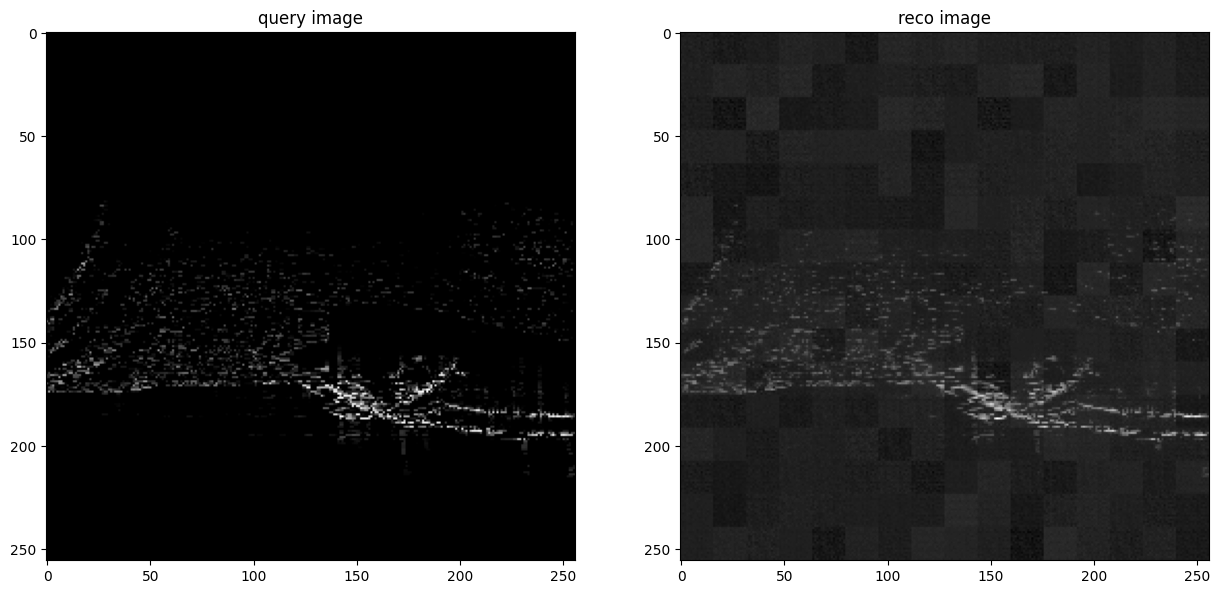

In [74]:
visualizer.analyze_feature_robustness(train_data, net)

iou: 0.9542710729272041
localization error: 0.2500 meters
orientation error : 0.9359 degrees


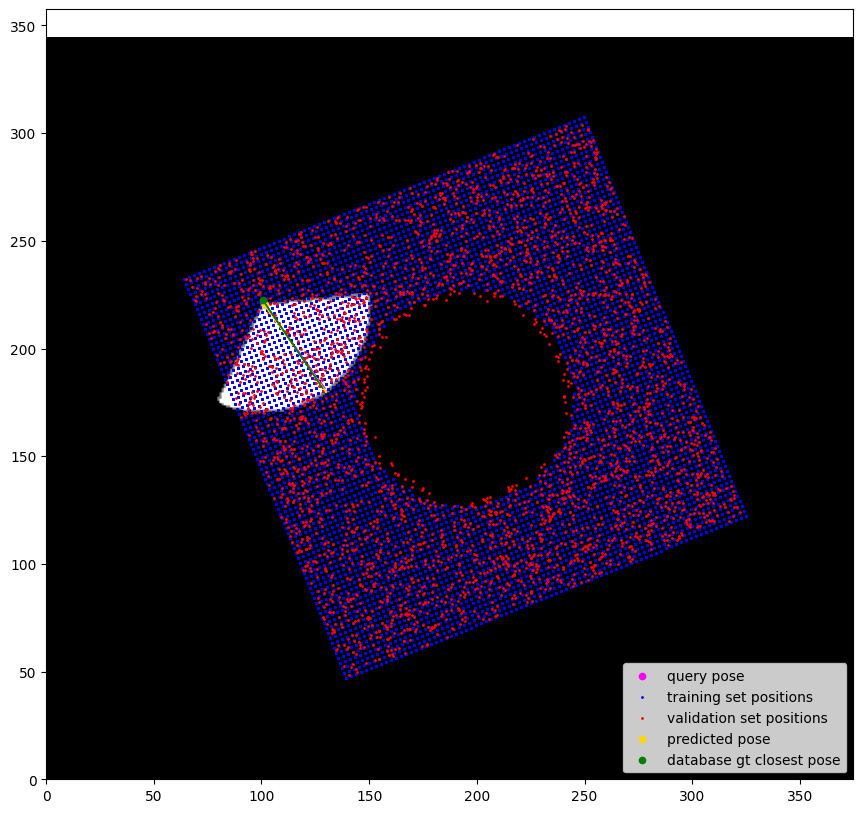

<Figure size 640x480 with 0 Axes>

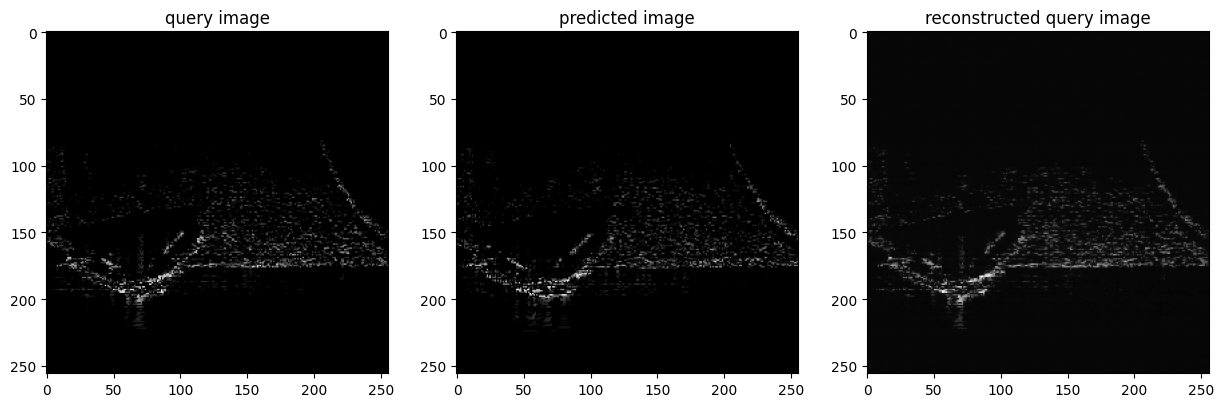

In [91]:
query_idx = random.randint(0, len(test_data))

loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [76]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(test_data))):
    loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_t = avg_loca_error
aoe_t = avg_orie_error

100%|███████████████████████████████████████| 3496/3496 [08:09<00:00,  7.14it/s]

average localization error: 1.7419 meters
average orientation error : 13.7132 degrees


In [77]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [78]:
loca_errors.argmax()

np.int64(396)

In [79]:
le = loca_errors[loca_errors<10]
oe = orie_errors[orie_errors<10]
print(le.mean())
print(oe.mean())

1.1282927
3.6712387


## Process real images

query_idx: 558
126.74988 189.71008 0.8785262 -129.66415
iou: 0.07630569484266801
localization error Upper:  5.950783 meters


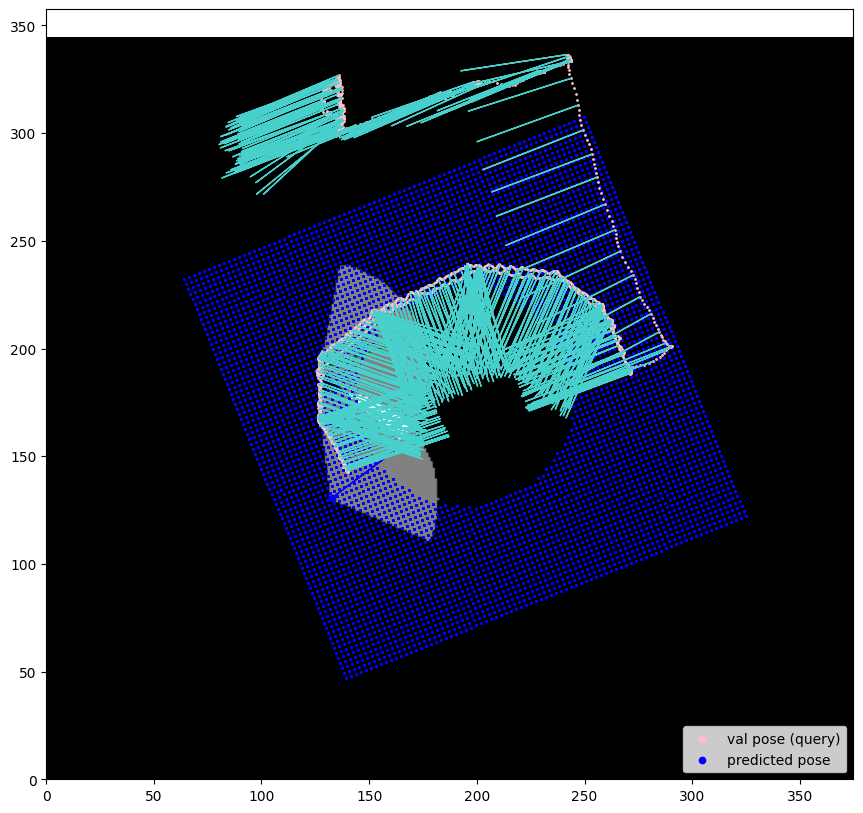

<Figure size 640x480 with 0 Axes>

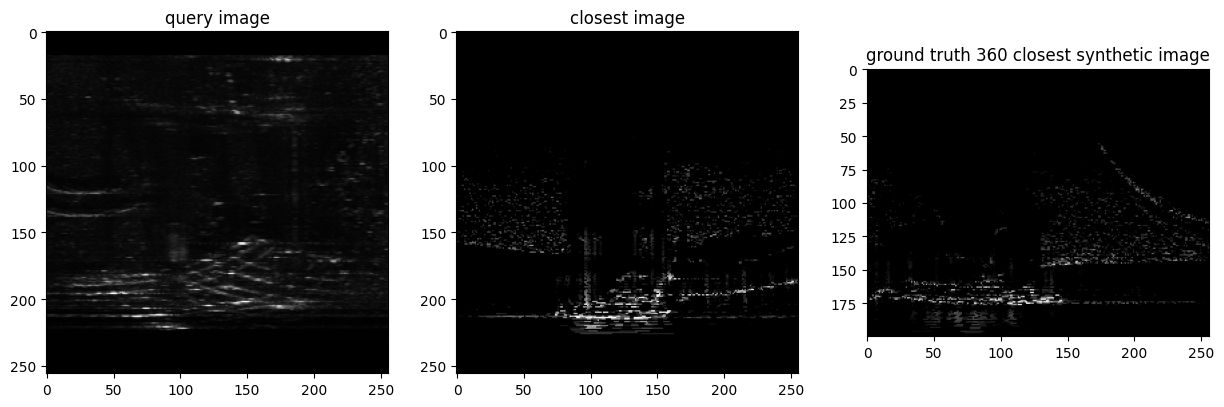

In [80]:
query_idx = random.randint(0, 600)
train_data.apply_random_rot = True
train_data.training = True
print("query_idx:", query_idx)
visualizer.process_real(query_idx, net, train_data, real_data)

## Process ONLY real images

In [81]:
real_data_train = load_only_real_datasets.SonarDescriptorOnlyRealDataset()
real_data_valid = load_only_real_datasets.SonarDescriptorOnlyRealDataset(real_data_train)

In [82]:
real_data_train.computeDescriptors(net)

computing dataset descriptors


100%|█████████████████████████████████████████| 710/710 [00:08<00:00, 81.43it/s]

descriptors computed!


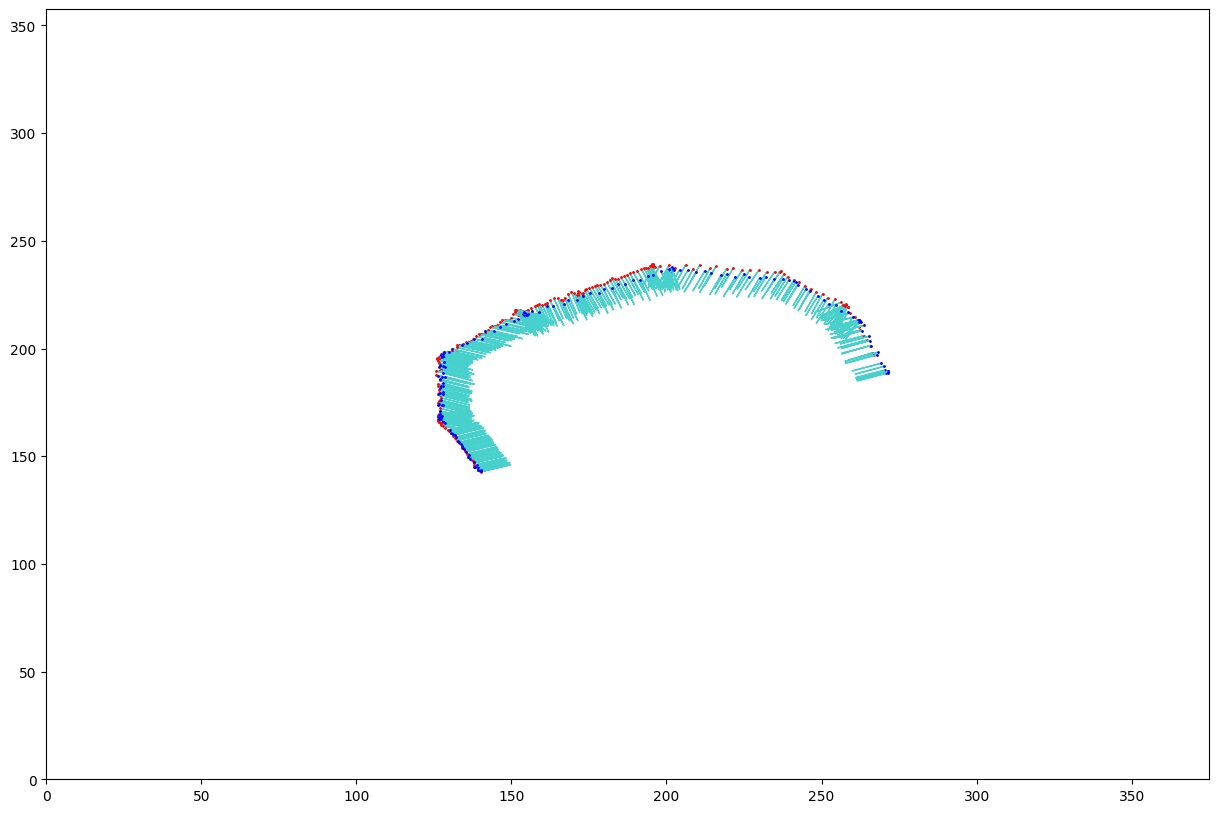

In [83]:
visualizer.visualize_real(train_data, real_data)

735
iou: 0.8303865939868569
localization error: 0.1669 meters
orientation error : 2.0569 degrees


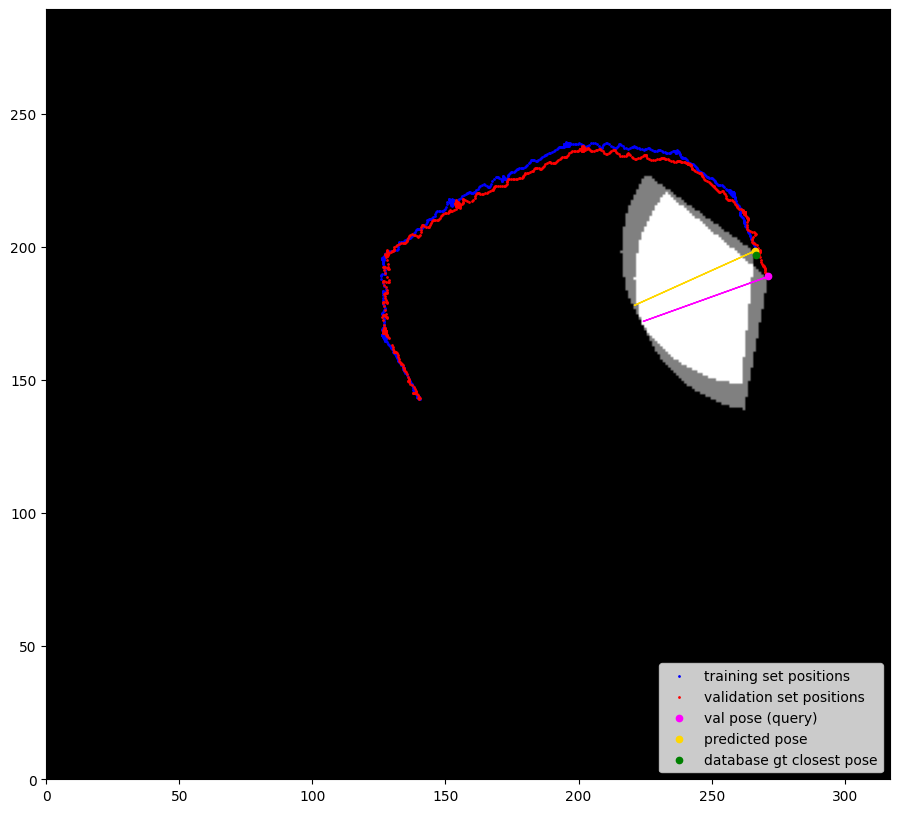

<Figure size 640x480 with 0 Axes>

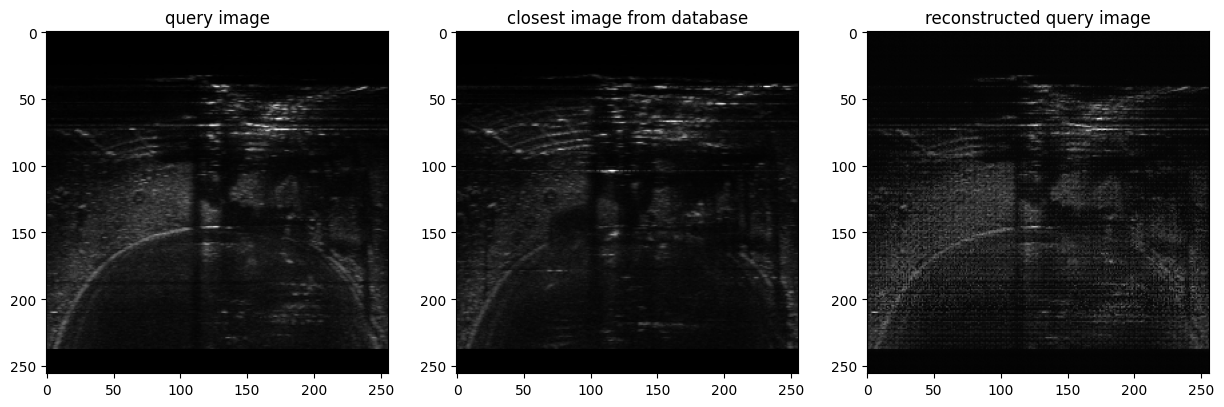

In [108]:
query_idx = random.randint(700, len(real_data_valid))
print(query_idx)
loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [93]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(real_data_valid))):
    loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.abs(np.array(orie_errors)).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_r = avg_loca_error
aoe_r = avg_orie_error

100%|█████████████████████████████████████████| 785/785 [00:21<00:00, 37.09it/s]

average localization error: 0.9149 meters
average orientation error : 13.2888 degrees


In [86]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [87]:
avg_orie_error.min()

np.float32(13.288846)

In [88]:
le = loca_errors[loca_errors<10]
oe = orie_errors[orie_errors<10]
print(le.mean())
print(oe.mean())

0.54997206
1.3570994


## Results

In [52]:
file_path = "results.csv"
metrics.save_results(model_name, total_params, training_time, inference_time_per_image, inference_memory_per_batch, ale_t, aoe_t, ale_r, aoe_r, file_path)

print(f"Model name: {model_name}")
print(f"Total parameters: {total_params}")
print(f"Training time: {training_time:6.4f} seconds")
print(f"Inference time per image: {inference_time_per_image:6.4f} seconds")
print(f"Inference memory per batch: {inference_memory_per_batch:6.4f} MB")
print(f"Average localization error in Test: {ale_t:6.4f} meters")
print(f"Average orientation error in Test: {aoe_t:6.4f} degrees")
print(f"Average localization error in Real: {ale_r:6.4f} meters")
print(f"Average orientation error in Real: {aoe_r:6.4f} degrees")

Model name: PVT_r
Total parameters: 20571337
Training time: 29791.2833 seconds
Inference time per image: 0.0018 seconds
Inference memory per batch: 382.5088 MB
Average localization error in Test: 8.7937 meters
Average orientation error in Test: 72.3110 degrees
Average localization error in Real: 3.0643 meters
Average orientation error in Real: 24.9699 degrees
